In [9]:
import time

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

from sklearn.cluster import KMeans
from sklearn import metrics
from sklearn.impute import KNNImputer
from math import floor
import seaborn as sns

import os

# Establecer la variable de entorno OMP_NUM_THREADS
os.environ["OMP_NUM_THREADS"] = "5"  # Puedes ajustar el número de hilos según tu configuración

In [27]:
### FUNCIONES DEFINIDAS ###
peso = 'ponde'

# Función de normalización
def norm_to_zero_one(df):
    return (df - df.min()) * 1.0 / (df.max() - df.min())

# Imputamos por vecinos más cercanos
def imputar_valores_perdidos(datos):
    imputer = KNNImputer(n_neighbors=3)
    datos_norm = datos.apply(norm_to_zero_one)
    datos_imputados_array = imputer.fit_transform(datos_norm)
    datos_norm2 = pd.DataFrame(datos_imputados_array, columns = datos.columns)
    datos = datos_norm2
    return datos

def kmeans(X_normal, n_clusters_arg=5, n_init_arg=5, random_state_arg=123456):
    print('----- Ejecutando k-Means',end='')
    k_means = KMeans(init='k-means++', n_clusters=n_clusters_arg, n_init=n_init_arg, random_state=random_state_arg)
    t = time.time()
    cluster_predict = k_means.fit_predict(X_normal,subset['ponde']) #se usa peso para cada objeto (factor de elevación)
    tiempo = time.time() - t
    print(": {:.2f} segundos, ".format(tiempo), end='')
    return tiempo, k_means, cluster_predict


### MEDIDAS
#índice de Calinski-Harabasz
def CH_score(X_normal, cluster_predict):
    metric_CH = metrics.calinski_harabasz_score(X_normal, cluster_predict)
    print("Calinski-Harabasz Index: {:.3f}, ".format(metric_CH), end='')
    return metric_CH


# Esto es opcional, el cálculo de Silhouette puede consumir mucha RAM.
# Si son muchos datos, digamos más de 10k, se puede seleccionar una muestra, p.ej., el 20%
def SC_score(X_normal, cluster_predict):
    muestra_silhouette = 0.2 if (len(X) > 10000) else 1.0
    metric_SC = metrics.silhouette_score(X_normal, cluster_predict, metric='euclidean', sample_size=floor(muestra_silhouette*len(X)), random_state=123456)
    print("Silhouette Coefficient: {:.5f}".format(metric_SC))
    return metric_SC

def tamano_clusters(clusters):
    print("Tamaño de cada cluster:")
    size=clusters['cluster'].value_counts()
    size = size.sort_index()
    tabla_tam_clusters = []
    
    for i,c in enumerate(size):
        print('%s: %5d (%5.2f%%)' % (i,c,100*c/len(clusters)))
        tabla_tam_clusters.append(i)
        
    return tabla_tam_clusters, size


### VISUALIZACIÓN
def heatmap(k_means):
    print("---------- Heatmap de centroides...")
    centers = pd.DataFrame(k_means.cluster_centers_,columns=list(X))
    centers_desnormal = centers.copy()

    # se convierten los centros a los rangos originales antes de normalizar
    for var in list(centers):
        centers_desnormal[var] = X[var].min() + centers[var] * (X[var].max() - X[var].min())

    plt.figure()
    centers.index += 1
    plt.figure()
    hm = sns.heatmap(centers, cmap="YlGnBu", annot=centers_desnormal, annot_kws={"fontsize":18}, fmt='.3f')
    hm.set_ylim(len(centers),0)
    hm.figure.set_size_inches(15,15)
    hm.figure.savefig("centroides.pdf")
    centers.index -= 1
    
def scatter(X_kmeans, colors):
    print("---------- Scatter matrix...")
    plt.figure()
    sns.set()
    variables = list(X_kmeans)
    variables.remove('cluster')
    X_kmeans['cluster'] += 1
    sns_plot = sns.pairplot(X_kmeans, vars=variables, hue="cluster", palette=colors, plot_kws={"s": 25}, diag_kind="hist") #en hue indicamos que la columna 'cluster' define los colores
    X_kmeans['cluster'] -= 1
    sns_plot.fig.subplots_adjust(wspace=.03, hspace=.03)
    sns_plot.fig.set_size_inches(15,15)
    #sns_plot.savefig("C:/Users/monic/Documents/DGIIM5/IN/practicas/p2/scatter.pdf") #Me da PermisionError
    plt.show()

----- Ejecutando k-Means: 0.07 segundos, 

Medidas


Calinski-Harabasz Index: 229.209, Silhouette Coefficient: 0.18423
Tamaño de cada cluster:
0:   281 (26.38%)
1:   152 (14.27%)
2:   188 (17.65%)
3:   269 (25.26%)
4:   175 (16.43%)
---------- Heatmap de centroides...


C:\Users\monic\AppData\Roaming\Python\Python311\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(


---------- Scatter matrix...


<Figure size 640x480 with 0 Axes>

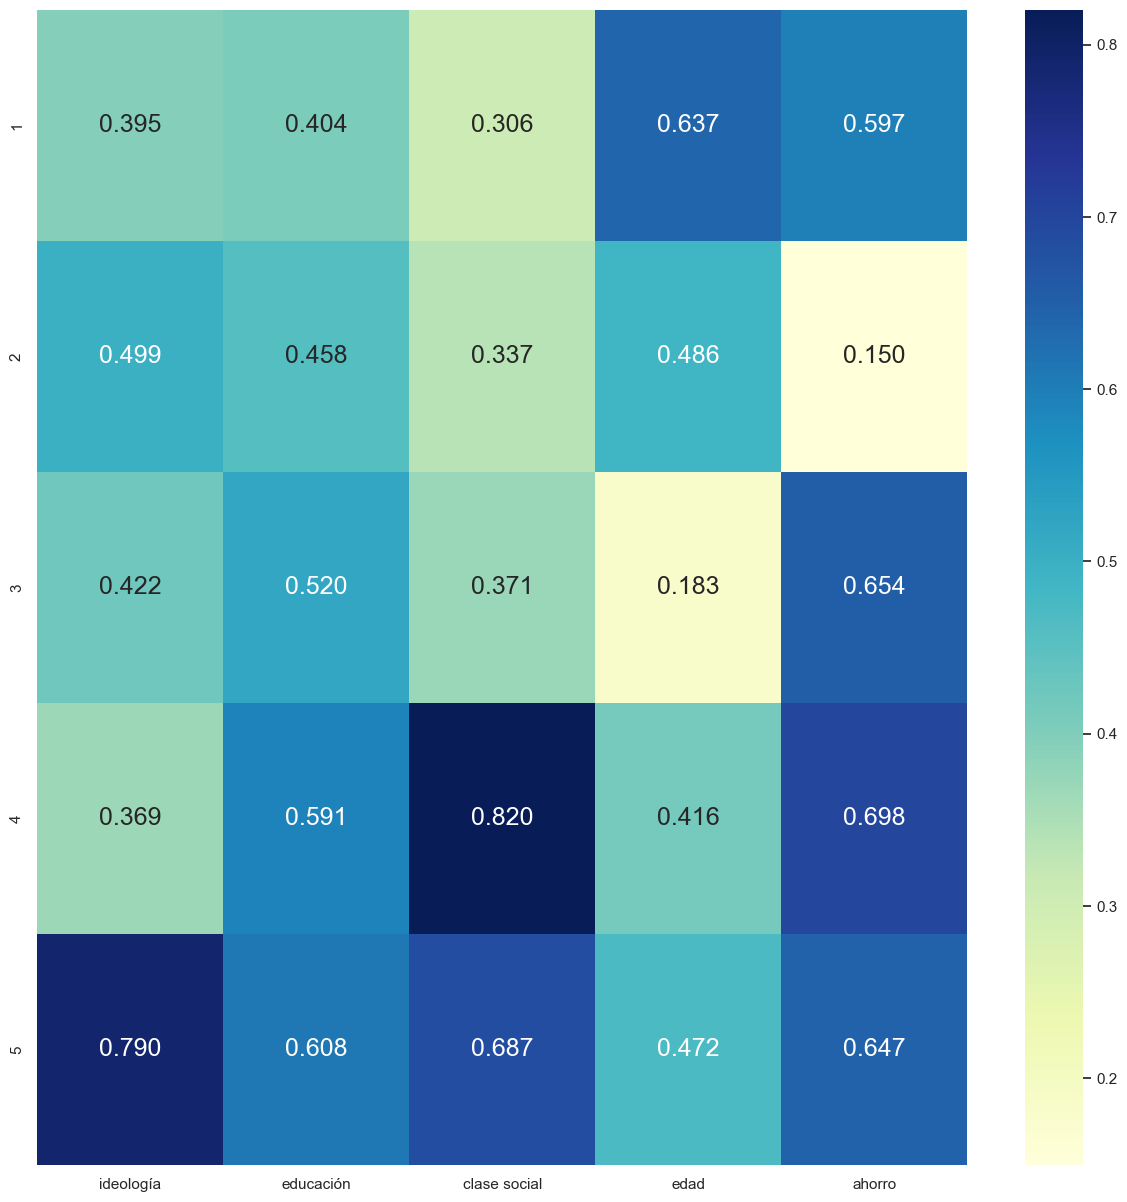

<Figure size 640x480 with 0 Axes>

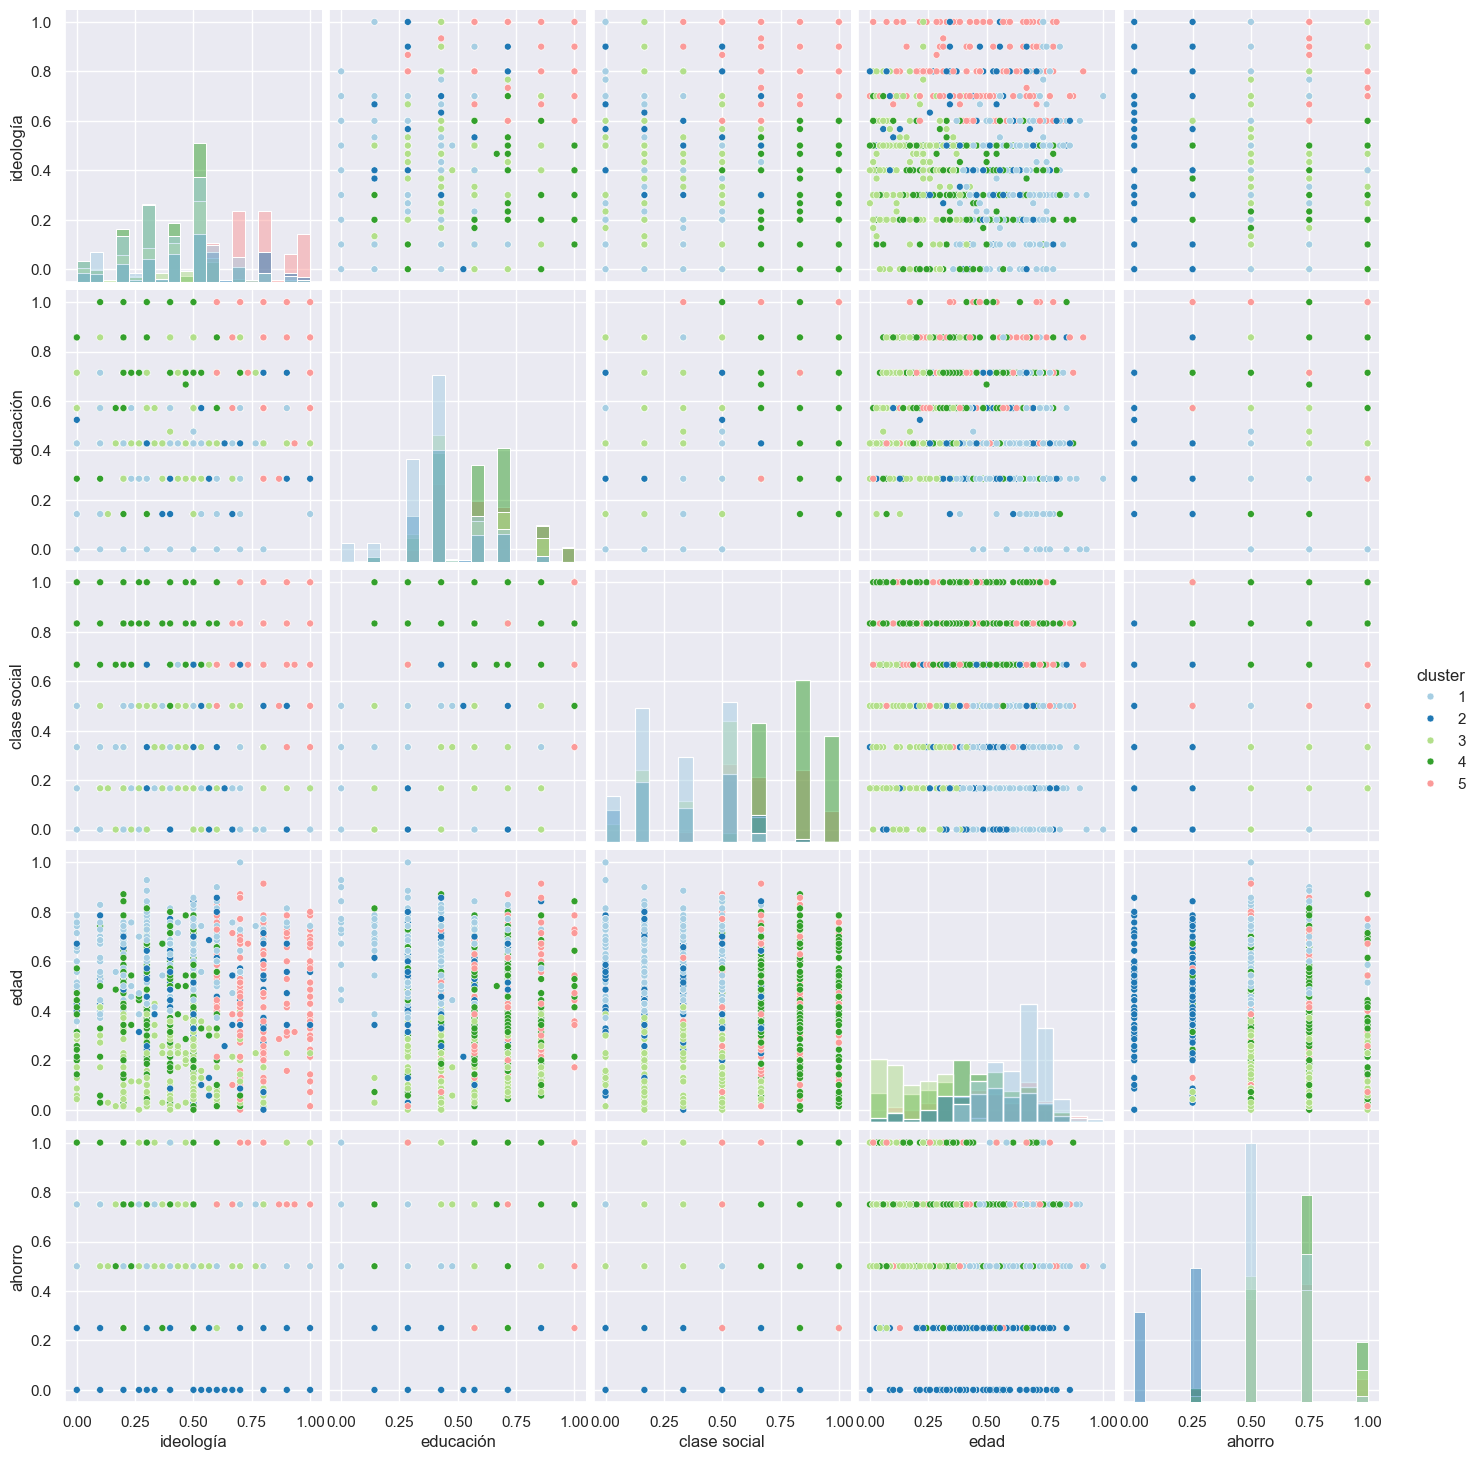

In [28]:
datos = pd.read_csv('03_Datos_noviembre_2023_num.csv')
peso = 'ponde'

#Imputamos los valores perdidos
datos=imputar_valores_perdidos(datos)

# Seleccionar casos, filtrando por sexo
subset = datos.loc[(datos['sexo']==1)] #solo mujeres (1==2 después de normalizar)

# Seleccionar variables de interés para clustering
# renombramos las variables por comodidad
subset=subset.rename(columns={"p7": "ideología", "edu": "educación", "cs": "clase social", "edad": "edad", "p1": "ahorro"})
usadas = ['ideología','educación','clase social','edad', 'ahorro']

n_var = len(usadas)
X = subset[usadas]

# normalizamos
X_normal = X.apply(norm_to_zero_one)


### Ejecutamos algoritmo 1
tiempo, kmeans_resultado, cluster_predict = kmeans(X_normal)

print("\n\nMedidas\n\n")
ch = CH_score(X_normal, cluster_predict)
sc = SC_score(X_normal, cluster_predict)


# se convierte la asignación de clusters a DataFrame
clusters = pd.DataFrame(cluster_predict,index=X.index,columns=['cluster'])

tamano, size=tamano_clusters(clusters)
#print(size)

heatmap(kmeans_resultado)

# se añade la asignación de clusters como columna a X
X_kmeans = pd.concat([X, clusters], axis=1)
k = len(size)
colors = sns.color_palette(palette='Paired', n_colors=k, desat=None)
scatter(X_kmeans, colors)